In [48]:
from pathlib import Path
data_path = Path.cwd() / "data"

# Emprise de la couche CLC 2012
# en EPSG:32632 (UTM zone 32N, utilisé par le CLC 2012)
bbox_clc2012 = [
    747547.4962000000523403, # Ouest
    4721805.0087999999523163, # Nord
    901147.4962000000523403, # Est
    4875405.0087999999523163  # Sud
]

# Ne pas excéder 2048x2048 pixels, le serveur WMS peut refuser les requêtes plus grandes
nrows = 2048
ncols = 2048

cellsize_x = (901147.4962 - 747547.4962) / 2048
cellsize_y = (4875405.0088 - 4721805.0088) / 2048

assert abs(cellsize_x - cellsize_y) < 1e-6, "cellsize_x and cellsize_y must be equal for square pixels"


xllcorner = bbox_clc2012[0]
yllcorner = bbox_clc2012[3]

print(f"cellsize {cellsize_x}, xll, yll: {xllcorner}, {yllcorner}")


cellsize 75.0, xll, yll: 747547.4962, 4875405.0088


4487085.8727147225 2169232.9827681123 4642554.1253072955 2321106.596637802
Abstract:  CLC2012 is one of the Corine Land Cover (CLC) datasets produced within the frame the Copernicus Land Monitoring Service referring to land cover / land use status of year 2018. CLC service has a long-time heritage (formerly known as "CORINE Land Cover Programme"), coordinated by the European Environment Agency (EEA). It provides consistent and thematically detailed information on land cover and land cover changes across Europe. CLC datasets are based on the classification of satellite images produced by the national teams of the participating countries - the EEA members and cooperating countries (EEA39). National CLC inventories are then further integrated into a seamless land cover map of Europe. The resulting European database relies on standard methodology and nomenclature with following base parameters: 44 classes in the hierarchical 3-level CLC nomenclature; minimum mapping unit (MMU) for status l

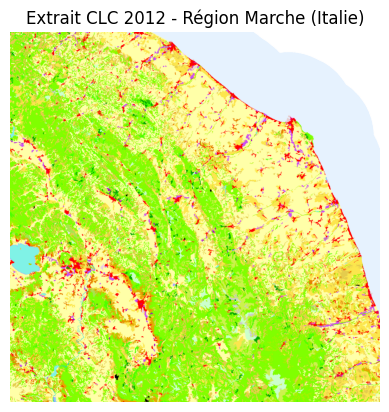

In [49]:
from owslib.wms import WebMapService
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

from pyproj import Transformer

# Reprojection vers EPSG:3035(m) https://epsg.io/3035
transformer = Transformer.from_crs("EPSG:32632", "EPSG:3035", always_xy=True)
xmin_3035, ymin_3035 = transformer.transform(bbox_clc2012[0], bbox_clc2012[1])
xmax_3035, ymax_3035 = transformer.transform(bbox_clc2012[2], bbox_clc2012[3])
print(xmin_3035, ymin_3035, xmax_3035, ymax_3035)

# Connexion au serveur WMS
wms_url = "https://image.discomap.eea.europa.eu/arcgis/services/Corine/CLC2012_WM/MapServer/WMSServer?"
wms = WebMapService(wms_url, version="1.3.0")
# print("Title: ", wms.identification.title)
# print("Type: ", wms.identification.type)
# print("Operations: ", [op.name for op in wms.operations])
# print("GetMap options: ", wms.getOperationByName('GetMap').formatOptions)
# wms.contents.keys()

# # Récupérer le nom de la couche disponible
# for layer_name in wms.contents.keys():
#     print(f"Nom de la couche : {wms.contents[layer_name]}")
    
layer_name = "Corine_Land_Cover_2012_raster59601"
layer = wms.contents[layer_name]
print("Abstract: ", layer.abstract)
print("BBox: ", layer.boundingBoxWGS84)
print("CRS: ", layer.crsOptions)
print("Styles: ", layer.styles)
print("Timestamps: ", layer.timepositions)

style = layer.styles['default']
print("Style name: ", style['title'])
print(style.keys())
legend_url = style['legend']

   
img = wms.getmap(
    layers=[layer_name],
    styles=[''],
    srs='EPSG:3035',
    bbox=(xmin_3035, ymin_3035, xmax_3035, ymax_3035),
    size=(ncols, nrows),
    format='image/png', # pour avoir une image indexée avec une palette de couleurs
    transparent=True
)

print(type(img))

land_cover_img = Image.open(BytesIO(img.read())).convert("P")  
print(land_cover_img.size, land_cover_img.mode)

# Afficher l’image
plt.imshow(land_cover_img)
plt.title("Extrait CLC 2012 - Région Marche (Italie)")
plt.axis('off')
plt.show()

Legend URL: https://image.discomap.eea.europa.eu/arcgis/services/Corine/CLC2012_WM/MapServer/WMSServer?request=GetLegendGraphic%26version=1.3.0%26format=image/png%26layer=Corine_Land_Cover_2012_raster59601
(534, 828) P


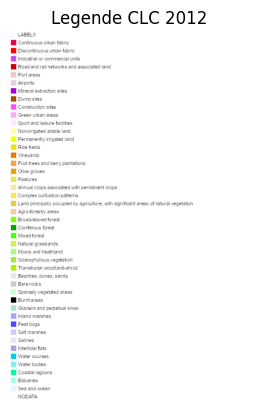

Nombre de couleurs : 216
10 Premières couleurs : [(0, 0, 0), (51, 0, 0), (102, 0, 0), (153, 0, 0), (204, 0, 0), (255, 0, 0), (0, 51, 0), (51, 51, 0), (102, 51, 0), (153, 51, 0)]


In [50]:
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from urllib.parse import urlencode
import urllib

from IPython.display import HTML
import pandas as pd


def get_and_plot_clc_legend(style):
    """Récupère et affiche la légende du CLC 2012."""
    # La légende est une image PNG
    legend_url = style['legend']
    print("Legend URL:", legend_url)
    
    # Utiliser un proxy si nécessaire
    # Si vous n'avez pas besoin de proxy, commentez les lignes suivantes
    proxy = "http://irproxy:8082"  
    proxy_handler = urllib.request.ProxyHandler({
        'http': proxy,
        'https': proxy
    })
    opener = urllib.request.build_opener(proxy_handler)

    with opener.open(legend_url) as response:
        coverage_data = response.read()

        
    legend = Image.open(BytesIO(coverage_data)).convert("P")
    print(legend.size, legend.mode)
    plt.imshow(legend)
    plt.axis('off')
    plt.title("Legende CLC 2012")
    plt.show()

    return legend


def get_palette(image):
    if image.mode == 'P':
        palette = image.getpalette()
        color_table = []
        for i in range(0, len(palette), 3):
            color = tuple(palette[i:i+3])
            if color not in color_table:
                color_table.append(color)
        filtered_colors = sorted(color_table, key=lambda x: (x[2], x[1], x[0]))
        #filtered_colors = [color for color in sorted(set(color_table))]  
        print("Nombre de couleurs :", len(filtered_colors))
        print("10 Premières couleurs :", [filtered_colors[i] for i in range(10)])

        return filtered_colors

legend = get_and_plot_clc_legend(style)
legend_palette = get_palette(legend)



In [51]:

color_table = get_palette(land_cover_img)

# Lit les couleurs de la légende
labels_df = pd.read_csv(data_path / "clc2000legend.csv", sep=";", encoding="utf-8")

# Création d'une nouvelle colonne avec la couleur RGB au format CSS
def parse_rgb_string(rgb_str):
    if pd.isna(rgb_str):
        r, g, b = 0, 0, 0
    else:
        r, g, b = map(int, rgb_str.split('-'))
    color =  f"rgb({r}, {g}, {b})"
    return f"<div style='width: 30px; height: 20px; background-color: {color}; border: 1px solid #ccc'></div>"

labels_df['COLOR'] = labels_df['RGB'].apply(parse_rgb_string)


# Afficher comme HTML
HTML(labels_df[['LABEL3', 'RGB', 'COLOR']].to_html(escape=False, index=False))

Nombre de couleurs : 32
10 Premières couleurs : [(0, 0, 0), (204, 0, 0), (255, 0, 0), (166, 77, 0), (230, 128, 0), (0, 166, 0), (230, 166, 0), (166, 241, 0), (77, 255, 0), (128, 255, 0)]


LABEL3,RGB,COLOR
Continuous urban fabric,230-000-077,
Discontinuous urban fabric,255-000-000,
Industrial or commercial units,204-077-242,
Road and rail networks and associated land,204-000-000,
Port areas,230-204-204,
Airports,230-204-230,
Mineral extraction sites,166-000-204,
Dump sites,166-077-000,
Construction sites,255-077-255,
Green urban areas,255-166-255,


CRS : EPSG:32632
Taille : 2048 2048
Bbox : BoundingBox(left=747547.4962, bottom=4721805.0088, right=901147.4962, top=4875405.0088)
<class 'numpy.ndarray'>


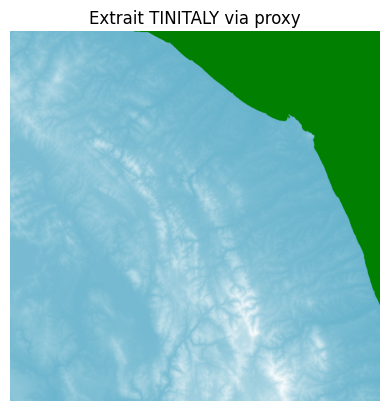

In [52]:
from owslib.wcs import WebCoverageService
from PIL import Image
from io import BytesIO
import urllib.request
from urllib.parse import urlencode
import rasterio
import matplotlib.pyplot as plt



proxy = "http://irproxy:8082"  
proxy_handler = urllib.request.ProxyHandler({
    'http': proxy,
    'https': proxy
})
opener = urllib.request.build_opener(proxy_handler)


# Connexion au service WCS  
wcs_url = "http://tinitaly.pi.ingv.it/TINItaly_1_1/wcs?"

### Uncommenter pour tester la connexion au WCS et connaitre les couches disponibles
# wcs = WebCoverageService(wcs_url, version="1.0.0")
# print("Title: ", wcs.identification.title)
# print("Type: ", wcs.identification.type)
# print("Operations: ", [op.name for op in wcs.operations])
# # Récupérer les couches disponibles
# for layer_name in wcs.contents.keys():
#     print(f"Nom de la couche : {layer_name}")
#     coverage = wcs.contents[layer_name]    
#     for format in coverage.supportedFormats:
#         print("Format supporté :", format)
#     # Affiche les CRS supportés
#     crs_list = coverage.supportedCRS
#     for crs in crs_list:
#         print("CRS:", crs)

# GetCoverage direct et par wcs à cause du proxy
layer_name = "TINItaly_1_1:tinitaly_dem"
params = {
    "service": "WCS",
    "request": "GetCoverage",
    "version": "1.0.0",
    "coverage": layer_name,
    "CRS": "EPSG:32632",
    "BBOX": ",".join(map(str, bbox_clc2012)),
    "format": "geotiff",
    "width": str(ncols),
    "height": str(nrows)
}
full_url = wcs_url + urlencode(params)

with opener.open(full_url) as response:
    coverage_data = response.read()
   

# Lire avec rasterio
with rasterio.open(BytesIO(coverage_data)) as src:
    print("CRS :", src.crs)
    print("Taille :", src.width, src.height)
    print("Bbox :", src.bounds)
    dem_array = src.read(1)
    print(type(dem_array))

    # Affichage
    plt.imshow(dem_array, cmap='ocean')
    plt.axis('off')
    plt.title("Extrait TINITALY via proxy")
    plt.show()




In [53]:
import os
import requests


def download_file(url, filename):
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(filename, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

url = "https://download.pangaea.de/dataset/935673/files/litology_italy.gpkg"
filename = data_path / "litology_italy.gpkg"

if os.path.exists(filename):
    print(f"Le fichier {filename} existe déjà.")
else:
    download_file(url, filename)


Le fichier /work/lecomtje/Repositories/rains/pyslam/preprocessing/data/litology_italy.gpkg existe déjà.


Nombre de géométries : 19
CRS : EPSG:4326
Bbox : [ 6.5465398  35.49129252 18.52094282 47.09323084]
Colonnes : Index(['cat', 'l3_mix', 'code', 'description', 'geometry'], dtype='object')
Nombre de géométries après clipping : 18
Bbox après clipping : [12.01789378 42.60893581 13.99670457 43.92241251]
Colonnes après clipping : Index(['cat', 'l3_mix', 'code', 'description', 'geometry'], dtype='object')


<Axes: >

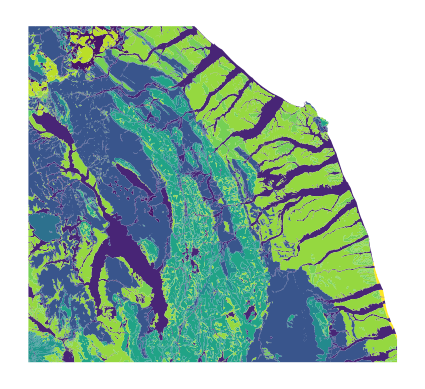

In [54]:
import geopandas as gpd
from shapely.geometry import box

gdf = gpd.read_file(filename)
print("Nombre de géométries :", len(gdf))
print("CRS :", gdf.crs)
print("Bbox :", gdf.total_bounds)
print("Colonnes :", gdf.columns)
# Afficher les 5 premières lignes
#print(gdf.head())       

# Projection vers EPSG:4326 du gpkg https://epsg.io/4326
assert gdf.crs == "EPSG:4326", "Le GeoDataFrame doit être en EPSG:4326"

transformer = Transformer.from_crs("EPSG:32632", "EPSG:4326", always_xy=True)
xmin_4326, ymin_4326 = transformer.transform(bbox_clc2012[0], bbox_clc2012[1])
xmax_4326, ymax_4326 = transformer.transform(bbox_clc2012[2], bbox_clc2012[3])
bbox = box(xmin_4326, ymin_4326, xmax_4326, ymax_4326)

gdf_clip = gpd.clip(gdf, bbox)
print("Nombre de géométries après clipping :", len(gdf_clip))
print("Bbox après clipping :", gdf_clip.total_bounds)
print("Colonnes après clipping :", gdf_clip.columns)

fig, ax = plt.subplots(1, 1)
plt.axis('off')
gdf_clip.plot(column='cat', ax=ax)


In [55]:

from rasterio.features import rasterize
from rasterio.transform import from_bounds
from PIL import Image


# Définir les dimensions et transformation
bounds = gdf_clip.total_bounds  

transform = from_bounds(*bounds, width=ncols, height=nrows)

# Préparer les shapes (géométrie, valeur)
shapes = [(geom, value) for geom, value in zip(gdf_clip.geometry, gdf_clip["cat"])]

# Rasteriser
raster = rasterize(
    shapes=shapes,
    out_shape=(ncols, nrows),
    transform=transform,
    fill=0,  # ID de fond (optionnel)
    dtype='uint8'
)


# Créer image indexée
soil_img = Image.fromarray(raster).convert("P")


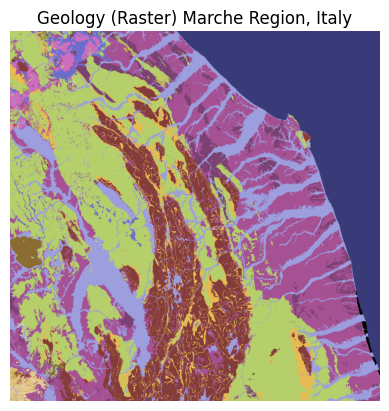

cat,description,COLOR
1,Anthropogenic deposits,
2,Chaotic – mélange,
3,"Alluvial, lacustrine, swamp and marine deposits. Eluvial and colluvial deposits",
4,Glacial drift,
5,Evaporite,
6,Siliciclastic sedimentary rocks,
7,Mass wasting material,
8,Lakes and Ice,
9,Lavas and basalts,
10,Marlstone,


In [56]:
import matplotlib.pyplot as plt

# Récupérer la colormap tab20b
cmap = plt.get_cmap('tab20b')
palette = []
for i in range(cmap.N):
    r, g, b, _ = cmap(i)
    palette.extend([int(r * 255), int(g * 255), int(b * 255)])
palette += [0] * (768 - len(palette))
soil_img.putpalette(palette)  

# Récupérer les 20 couleurs (tab20b est une ListedColormap)
#colors = [list(cmap(i))*255 for i in range(cmap.N)]
#print(colors)
soil_legend = gdf_clip[['cat', 'description']].sort_values('cat')
soil_legend['RGB'] = soil_legend['cat'].apply(lambda x: f"{palette[x*3]}-{palette[x*3+1]}-{palette[x*3+2]}")
soil_legend['COLOR'] = soil_legend['RGB'].apply(parse_rgb_string)

# Sauvegarder ou afficher
plt.imshow(soil_img)
plt.axis('off')
plt.title("Geology (Raster) Marche Region, Italy")
plt.show()

# Afficher comme HTML
HTML(soil_legend[['cat', 'description', 'COLOR']].to_html(escape=False, index=False))


In [57]:
import influxdb_client, os, time
from influxdb_client import InfluxDBClient, Point, WritePrecision
from influxdb_client.client.write_api import SYNCHRONOUS, ASYNCHRONOUS
import numpy as np
import pandas as pd

token = "bdfWYR9mSnsAOUy2cVfiGe_AIlpMby_JkJBgMCXI0_IyLSwjmmSiNlbpG1yBjSlaNUVfook4_iXfTZfBmuYCEg=="
org = "IFPEN"
url = "http://10.25.11.36:8086"

time_start = "2013-01-01T00:00:00Z"
time_stop = "2015-01-01T00:00:00Z"


client = influxdb_client.InfluxDBClient(url=url, token=token, org=org)
query_api = client.query_api()
query = """from(bucket: "rainfall")
  |> range(start: {}, stop: {})
  |> filter(fn: (r) => r["_measurement"] == "rainfall")
  |> filter(fn: (r) => r["_field"] == "Precipitazione")  // ou "Neve"
  |> drop(columns: ["Codice_stazione"])
  |> aggregateWindow(every: 2d, fn: sum, createEmpty: false)
  |> pivot(rowKey: ["_time"], columnKey: [ "_field", "Codice_sensore"], valueColumn: "_value")
  |> yield(name: "sum")
  """

# Obtenir directement un DataFrame
df = query_api.query_data_frame(query.format(time_start, time_stop))
df.head()


,result,table,_time,_start,_stop,_measurement,Precipitazione_1056,Precipitazione_1064,Precipitazione_1072,Precipitazione_1124,...,Precipitazione_2988,Precipitazione_2992,Precipitazione_2996,Precipitazione_3006,Precipitazione_3010,Precipitazione_3014,Precipitazione_3017,Precipitazione_3018,Precipitazione_3021,Precipitazione_3030
0,sum,0,2013-01-03 00:00:00+00:00,2013-01-01 00:00:00+00:00,2015-01-01 00:00:00+00:00,rainfall,0.2,0.0,0.2,0.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,sum,0,2013-01-05 00:00:00+00:00,2013-01-01 00:00:00+00:00,2015-01-01 00:00:00+00:00,rainfall,0.6,1.0,0.2,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,sum,0,2013-01-07 00:00:00+00:00,2013-01-01 00:00:00+00:00,2015-01-01 00:00:00+00:00,rainfall,0.4,0.0,0.2,0.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,sum,0,2013-01-09 00:00:00+00:00,2013-01-01 00:00:00+00:00,2015-01-01 00:00:00+00:00,rainfall,0.2,0.0,0.6,0.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,sum,0,2013-01-11 00:00:00+00:00,2013-01-01 00:00:00+00:00,2015-01-01 00:00:00+00:00,rainfall,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
df["_time"] = pd.to_datetime(df["_time"])
df = df.set_index("_time")

print(df.columns)

Index(['result', 'table', '_start', '_stop', '_measurement',
       'Precipitazione_1056', 'Precipitazione_1064', 'Precipitazione_1072',
       'Precipitazione_1124', 'Precipitazione_1132',
       ...
       'Precipitazione_2988', 'Precipitazione_2992', 'Precipitazione_2996',
       'Precipitazione_3006', 'Precipitazione_3010', 'Precipitazione_3014',
       'Precipitazione_3017', 'Precipitazione_3018', 'Precipitazione_3021',
       'Precipitazione_3030'],
      dtype='object', length=137)


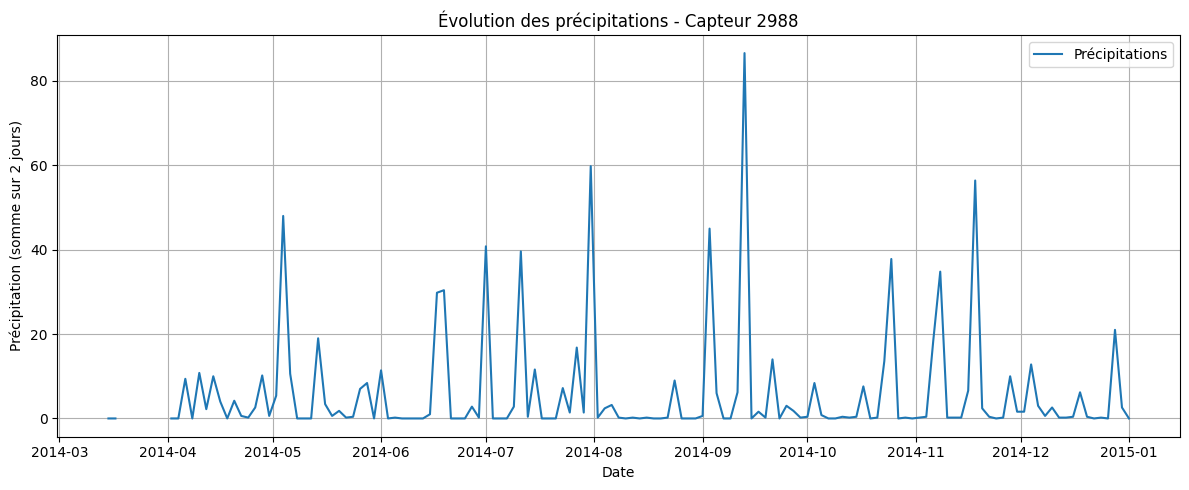

In [59]:
import matplotlib.pyplot as plt
capteur = 2988


plt.figure(figsize=(12, 5))
plt.plot(df.index, df[f"Precipitazione_{capteur}"], label="Précipitations")
plt.xlabel("Date")
plt.ylabel("Précipitation (somme sur 2 jours)")
plt.title(f"Évolution des précipitations - Capteur {capteur}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [60]:
from pathlib import Path
import geopandas as gpd
from shapely.geometry import box
from pyproj import Transformer
import matplotlib.pyplot as plt



df_stations = gpd.read_file(data_path / "stations.gpkg")
print("Nombre de géométries :", len(df_stations))
print("CRS :", df_stations.crs)
print("Bbox :", df_stations.total_bounds)
print("Colonnes :", df_stations.columns)
# Afficher les 5 premières lignes
#print(df_stations.head())       

# Projection vers EPSG:4326 du gpkg https://epsg.io/4326
assert df_stations.crs == "EPSG:4326", "Le GeoDataFrame doit être en EPSG:4326"

transformer = Transformer.from_crs("EPSG:32632", "EPSG:4326", always_xy=True)
xmin_4326, ymin_4326 = transformer.transform(bbox_clc2012[0], bbox_clc2012[1])
xmax_4326, ymax_4326 = transformer.transform(bbox_clc2012[2], bbox_clc2012[3])
bbox = box(xmin_4326, ymin_4326, xmax_4326, ymax_4326)

df_stations_clip = gpd.clip(df_stations, bbox)
print("Nombre de géométries :", len(df_stations_clip))
print("CRS :", df_stations_clip.crs)
print("Bbox :", df_stations_clip.total_bounds)
print("Colonnes :", df_stations_clip.columns)


df_stations_clip.head()

Nombre de géométries : 247
CRS : EPSG:4326
Bbox : [12.19 42.55 13.89 44.05]
Colonnes : Index(['id', 'name', 'start', 'end', 'geometry'], dtype='object')
Nombre de géométries : 242
CRS : EPSG:4326
Bbox : [12.19 42.63 13.89 43.91]
Colonnes : Index(['id', 'name', 'start', 'end', 'geometry'], dtype='object')


,id,name,start,end,geometry
9,2186,Amatrice,1951-01-01,2013-07-01,POINT (13.29 42.63)
10,2956,Amatrice,2013-10-02,2024-10-26,POINT (13.3 42.63)
199,2210,Martino,1952-04-18,2003-02-03,POINT (13.45 42.73)
53,1364,Capodacqua,2006-04-14,2024-10-26,POINT (13.24 42.74)
236,1356,Umito,2003-06-26,2024-10-26,POINT (13.41 42.74)


In [67]:
import numpy as np
import re

def parse_offset(delai):
    match = re.fullmatch(r"(\d+)([ymwdh])", delai)
    if not match:
        raise ValueError("Délai invalide : utiliser des formats comme '1y', '6m', '30d'")
    value, unit = match.groups()
    value = int(value)
    if unit == "y":
        return pd.DateOffset(years=value)
    elif unit == "m":
        return pd.DateOffset(months=value)
    elif unit == "w":
        return pd.Timedelta(weeks=value)
    elif unit == "d":
        return pd.Timedelta(days=value)
    elif unit == "h":
        return pd.Timedelta(hours=value)
    else:
        raise ValueError("Unité non reconnue")
    
def add_precipitation(client, dfita, rain_start="2013-01-01T00:00:00Z", delai="1m"):
    """
    Ajoute la colonne 'rain' au DataFrame dfita avec les précipitations pour chaque station.
    Les paramètres rain_start et delai définissent la période de récupération des données.
    Le paramètre delai doit être au format '1y', '6m', '30d', '1w', '12h' etc.
    """
    rain_stop = pd.to_datetime(rain_start) + parse_offset(delai)
       
    query = """from(bucket: "rainfall")
        |> range(start: {}, stop: {})
        |> filter(fn: (r) => r._measurement == "rainfall")
        |> filter(fn: (r) => r._field == "Precipitazione")
        |> filter(fn: (r) => r.Codice_sensore == "{}")
        |> sum()"""
    
    dfita = dfita.copy()  # Ensure we are working on a copy to avoid SettingWithCopyWarning
    dfita["rain"] = np.nan
    query_api = client.query_api()
    for id in dfita["id"]:
        tables = query_api.query(query.format(rain_start, rain_stop.strftime('%Y-%m-%dT%H:%M:%SZ'), id))
        if len(tables) > 0:
            record = tables[0].records[0]
            dfita.loc[dfita["id"] == id, "rain"] = record.get_value()

    dfita = dfita.dropna(subset=["rain"])
    dfita = dfita[dfita['rain'] > 0]
    return dfita

def draw_station_dataframe(df_stations_clip, column_name):
    x = df_stations_clip.geometry.x
    y = df_stations_clip.geometry.y
    values = df_stations_clip[column_name]
    
    plt.scatter(x, y, c=values, cmap='viridis', s=50)  # 'c' pour coloriser, 'cmap' pour la palette de couleurs
    plt.colorbar(label=column_name)  # Ajouter une barre de couleur
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"Stations colorisées par {column_name}")
    plt.axis('off')  # Pour ne pas afficher les axes
    plt.show()



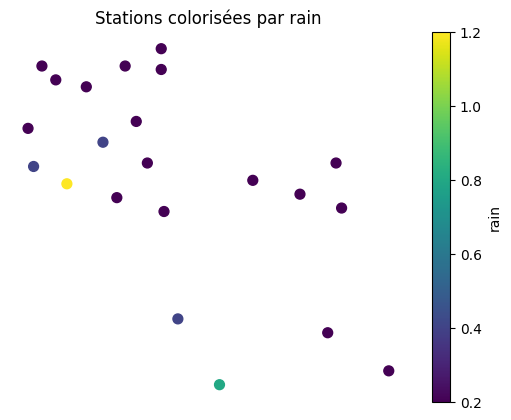

,id,name,start,end,geometry,rain
70,2695,Endesa,2006-12-07,2024-10-26,POINT (13.1 42.93),0.8
191,2733,Goretti,2009-11-30,2024-10-26,POINT (13.71 42.97),0.2
225,2177,Servigliano,1951-01-01,2015-01-01,POINT (13.49 43.08),0.2
188,2814,Rostighello,2009-11-30,2024-10-26,POINT (13.54 43.44),0.2
227,2840,Sorti,2009-11-30,2024-10-26,POINT (12.95 43.12),0.4


In [78]:

df_stations_1d = add_precipitation(client, df_stations_clip, delai="1d")
draw_station_dataframe(df_stations_1d, 'rain')
df_stations_1d.head()

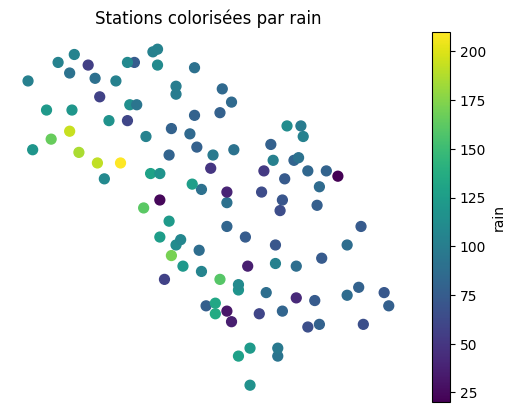

,id,name,start,end,geometry,rain
9,2186,Amatrice,1951-01-01,2013-07-01,POINT (13.29 42.63),115.4
53,1364,Capodacqua,2006-04-14,2024-10-26,POINT (13.24 42.74),128.0
236,1356,Umito,2003-06-26,2024-10-26,POINT (13.41 42.74),93.2
19,2202,Tronto,1951-01-01,2015-01-01,POINT (13.29 42.77),123.0
4,2883,Terme,2011-11-11,2013-12-16,POINT (13.41 42.77),97.0


In [69]:
df_stations_1m = add_precipitation(client, df_stations_clip, delai="1m")
draw_station_dataframe(df_stations_1m, 'rain')
df_stations_1m.head()

In [77]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging

def krige_rain_to_raster(gdf, value_column, bbox, nrows=2048, ncols=2048):
    """
    Interpolation par krigeage sur une grille régulière.
    """
    # S'assurer du bon système de coordonnées
    if gdf.crs.to_epsg() != 32632:
        gdf = gdf.to_crs(epsg=32632)

    # Extraire les coordonnées et valeurs
    x = gdf.geometry.x.values
    y = gdf.geometry.y.values
    z = gdf[value_column].values

    # Définir la grille
    xmin, ymin, xmax, ymax = bbox
    gridx = np.linspace(xmin, xmax, ncols)
    gridy = np.linspace(ymin, ymax, nrows)

    # Appliquer le krigeage
    OK = OrdinaryKriging(
        x, y, z,
        variogram_model='spherical',  # 'linear', 'gaussian', 'spherical', 'exponential'
        verbose=True,
        enable_plotting=False
    )
    z_kriged, ss = OK.execute('grid', gridx, gridy)
    print("Krigeage terminé.")
   
    return z_kriged



rain_raster_1m = krige_rain_to_raster(df_stations_1m, value_column="rain", bbox=bbox_clc2012, nrows=nrows, ncols=ncols)


Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'spherical' Variogram Model
Partial Sill: 526.8305664109104
Full Sill: 1214.8462271770038
Range: 51107.08968065897
Nugget: 688.0156607660934 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



Krigeage terminé.


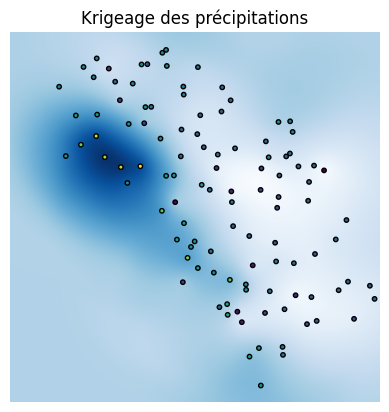

In [76]:
def plot_rain_raster(rain_raster, bbox_clc2012, df_stations_data):
    """
    Affiche le raster des précipitations avec les stations.
    """
    # S'assurer que le GeoDataFrame est en EPSG:32632
    if df_stations_data.crs.to_epsg() != 32632:
        df_stations_data = df_stations_data.to_crs(epsg=32632)

    x = df_stations_data.geometry.x.values
    y = df_stations_data.geometry.y.values
    z = df_stations_data["rain"].values

    # Définir l'extent pour imshow
    xmin, ymin, xmax, ymax = bbox_clc2012

    plt.imshow(rain_raster, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='Blues')   
    plt.scatter(x, y, c=z, edgecolor='black', s=10)
    plt.title("Krigeage des précipitations")
    plt.axis('off')
    plt.show()
plot_rain_raster(rain_raster_1m, bbox_clc2012, df_stations_1m)